#### Alumna: Geraldine Cacciatore

# Caso práctico: empresa telefónica

In [208]:
#Importo las librerias que voy a necesitar

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from dateutil.rrule import rrule, MONTHLY
import pickle #Los objetos de python se guardan en estas librerias

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression 
from sklearn.model_selection import cross_val_score


from sklearn.preprocessing import StandardScaler



## 1) Carga de datos y construcción de tablones

#### Carga de datos (dicimebre)

In [6]:
clientes_diciembre = pd.read_csv("clientes_diciembre.csv", sep='|')
consumos_diciembre = pd.read_csv("consumos_diciembre.csv", sep='|')
financiacion_diciembre = pd.read_csv("financiacion_diciembre.csv", sep='|')
productos_diciembre = pd.read_csv("productos_diciembre.csv", sep='|')

In [7]:
clientes_diciembre.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN


In [8]:
consumos_diciembre.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal
0,1,110,79,10897,12806,13751
1,2,189,89,18657,6499,10862
2,3,129,30,15511,17013,16743
3,4,51,52,12670,3393,6771
4,5,183,3,23756,18436,4485


In [9]:
financiacion_diciembre.head()

,id,financiacion,imp_financ,descuentos
0,2,NaN,NaN,SI
1,3,NaN,NaN,SI
2,7,SI,31.553269,NaN
3,11,NaN,NaN,SI
4,12,NaN,NaN,SI


In [10]:
productos_diciembre.head()

,id,conexion,vel_conexion,TV
0,1,FIBRA,50MB,tv-futbol
1,2,FIBRA,600MB,tv-futbol
2,3,ADSL,35MB,tv-futbol
3,4,FIBRA,200MB,tv-familiar
4,5,ADSL,10MB,tv-futbol


In [11]:
clientes_diciembre.shape

(95467, 8)

In [12]:
consumos_diciembre.shape

(95467, 6)

In [13]:
financiacion_diciembre.shape #Esta tiene menos datos (filas)

(24198, 4)

In [14]:
productos_diciembre.shape

(95467, 4)

### Creacion del tablón (diciembre)

#### Vamos a utilizar la función marge que tiene por defecto 'how = inner' ya que vemos que los dataframes tienen las mismas medidas

In [15]:
cliente_consumos_diciembre = pd.merge(clientes_diciembre,consumos_diciembre, on='id')

#cliente_consumos_diciembre.head()

#cliente_consumos_diciembre.shape  -> (95467, 13)

In [16]:
cliente_consumos_productos_diciembre = pd.merge(cliente_consumos_diciembre,productos_diciembre, on='id')

#cliente_consumos_productos_diciembre.shape  -> (95467, 16)

#### Vamos a utilizar la función marge que tiene con 'how = left' ya que vemos que los dataframes no tienen las mismas medidas, y queremos que se unan en base al dataframe que se creo hasta ahora

In [17]:
datos_diciembre = pd.merge(cliente_consumos_productos_diciembre,financiacion_diciembre, how='left',on='id', )

#Comprobamos que tengamos la mimsa cantidad de filas que al principio en el datafreme de clientes y que esten todas las columas
#datos_diciembre.shape  -> (95467, 19)

In [18]:
datos_diciembre.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,110,79,10897,12806,13751,FIBRA,50MB,tv-futbol,NaN,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862,FIBRA,600MB,tv-futbol,NaN,NaN,SI
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,129,30,15511,17013,16743,ADSL,35MB,tv-futbol,NaN,NaN,SI
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,51,52,12670,3393,6771,FIBRA,200MB,tv-familiar,NaN,NaN,NaN
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN,183,3,23756,18436,4485,ADSL,10MB,tv-futbol,NaN,NaN,NaN


### Carga de datos (enero)
Repetimos el mismo procedimiento

In [19]:
clientes_enero = pd.read_csv("clientes_enero.csv", sep='|')
consumos_enero = pd.read_csv("consumos_enero.csv", sep='|')
financiacion_enero = pd.read_csv("financiacion_enero.csv", sep='|')
productos_enero = pd.read_csv("productos_enero.csv", sep='|')

In [20]:
clientes_enero.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN
4,6,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN


In [21]:
consumos_enero.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal
0,1,95,19,6525,7634,18520
1,2,44,36,14471,14541,8016
2,3,94,27,1428,5248,7106
3,4,186,20,20083,7372,5052
4,6,37,32,19078,5009,8686


In [22]:
financiacion_enero.head()

,id,financiacion,imp_financ,descuentos
0,2,NaN,NaN,SI
1,3,NaN,NaN,SI
2,7,SI,31.553269,NaN
3,11,NaN,NaN,SI
4,12,NaN,NaN,SI


In [23]:
clientes_enero.shape

(92711, 8)

In [24]:
consumos_enero.shape

(92711, 6)

In [25]:
financiacion_enero.shape

(25332, 4)

In [26]:
productos_enero.shape

(92711, 4)

### Creacion del tablón (enero)

#### Vamos a utilizar la función marge que tiene por defecto 'how = inner' ya que vemos que los dataframes tienen las mismas medidas

In [27]:
cliente_consumos_enero = pd.merge(clientes_enero,consumos_enero, on='id')

#cliente_consumos_enero.head()

#cliente_consumos_enero.shape -> (92711, 13)

In [28]:
cliente_consumos_productos_enero = pd.merge(cliente_consumos_enero,productos_enero, on='id')

#cliente_consumos_productos_enero.head()

#cliente_consumos_productos_enero.shape -> (92711, 16)

#### Vamos a utilizar la función marge que tiene con 'how = left' ya que vemos que los dataframes no tienen las mismas medidas, y queremos que se unan en base al dataframe que se creo hasta ahora

In [29]:
datos_enero = pd.merge(cliente_consumos_productos_enero,financiacion_enero, how='left',on='id', )

#Comprobamos que tengamos la mimsa cantidad de filas que al principio en el datafreme de clientes y que esten todas las columas
#datos_enero.shape -> (92711, 19)

In [30]:
datos_enero.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,95,19,6525,7634,18520,FIBRA,50MB,tv-futbol,NaN,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,44,36,14471,14541,8016,FIBRA,600MB,tv-futbol,NaN,NaN,SI
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,94,27,1428,5248,7106,ADSL,35MB,tv-futbol,NaN,NaN,SI
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,186,20,20083,7372,5052,FIBRA,200MB,tv-familiar,NaN,NaN,NaN
4,6,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN,37,32,19078,5009,8686,FIBRA,200MB,tv-futbol,NaN,NaN,NaN


### Creacion de la variable target
Mi variable debe decirme los clientes retenidos: los que estaban en diciembre y siguen en enero.

Finalmente tenemos que obterner 0 = cliente retenido, 1 = cliente que se va.

In [31]:
# Quiero saber los clientes que son los que estaban en diciembre y siguen en Enero (por eso uso el 'inner')
datos_retenidos = pd.merge(datos_enero,datos_diciembre, on = 'id')
datos_retenidos #estos son los que estan en la compania en enero, el resto se fueron.

,id,edad_x,facturacion_x,antiguedad_x,provincia_x,num_lineas_x,num_dt_x,incidencia_x,num_llamad_ent_x,num_llamad_sal_x,...,num_llamad_sal_y,mb_datos_y,seg_llamad_ent_y,seg_llamad_sal_y,conexion_y,vel_conexion_y,TV_y,financiacion_y,imp_financ_y,descuentos_y
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,95,19,...,79,10897,12806,13751,FIBRA,50MB,tv-futbol,NaN,NaN,NaN
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,44,36,...,89,18657,6499,10862,FIBRA,600MB,tv-futbol,NaN,NaN,SI
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,94,27,...,30,15511,17013,16743,ADSL,35MB,tv-futbol,NaN,NaN,SI
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,186,20,...,52,12670,3393,6771,FIBRA,200MB,tv-familiar,NaN,NaN,NaN
4,6,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN,37,32,...,51,18428,8956,4764,FIBRA,200MB,tv-futbol,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88377,99995,65,173.741667,03/05/2019 12:00 AM,Murcia,5,NaN,NaN,42,17,...,98,13403,6197,6853,ADSL,35MB,tv-familiar,SI,23.138779,NaN
88378,99996,36,215.890326,04/09/2013 01:33 PM,Guadalajara,3,NaN,NaN,217,96,...,13,5291,3684,1667,ADSL,30MB,tv-futbol,NaN,NaN,NaN
88379,99997,68,285.890750,08/08/2003 11:57 PM,Asturias,5,NaN,NaN,168,99,...,20,20002,572,5679,FIBRA,200MB,tv-futbol,SI,14.616422,NaN
88380,99998,20,383.167610,03/27/2013 08:07 PM,Álava,4,NaN,NaN,188,71,...,26,16448,833,14398,ADSL,20MB,tv-futbol,NaN,NaN,NaN


In [32]:
#tomo los id:
id_retenidos = datos_retenidos['id']
#los paso a data frame:
id_retenidos2 = pd.DataFrame(id_retenidos, columns = ['id'])
id_retenidos2

,id
0,1
1,2
2,3
3,4
4,6
...,...
88377,99995
88378,99996
88379,99997
88380,99998


In [33]:
#le agrego una columna:
id_retenidos2.insert(1,'y_cliente', '0') 
# y_cliente es 0 porque son los que permanecen. Me interesa (exito = 1) los que se van.
# Después voy a llevar esta columna "y_cliente" al data set de diciembre, los clientes que sean NA seran 1 (exito, que se han ido)

In [34]:
datos_diciembre = pd.merge(datos_diciembre, id_retenidos2,on='id',how='left') 
datos_diciembre
#datos_diciembre me queda con la columna y_cliente con 0 y NaN (son los que se fueron)

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,y_cliente
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,110,79,10897,12806,13751,FIBRA,50MB,tv-futbol,NaN,NaN,NaN,0
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862,FIBRA,600MB,tv-futbol,NaN,NaN,SI,0
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,129,30,15511,17013,16743,ADSL,35MB,tv-futbol,NaN,NaN,SI,0
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,51,52,12670,3393,6771,FIBRA,200MB,tv-familiar,NaN,NaN,NaN,0
4,5,25,22.302845,08/29/1997 02:19 AM,Tarragona,2,2.0,NaN,183,3,23756,18436,4485,ADSL,10MB,tv-futbol,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95462,99995,65,173.741667,03/05/2019 12:00 AM,Murcia,5,NaN,NaN,121,98,13403,6197,6853,ADSL,35MB,tv-familiar,SI,23.138779,NaN,0
95463,99996,36,215.890326,04/09/2013 01:33 PM,Guadalajara,3,NaN,NaN,98,13,5291,3684,1667,ADSL,30MB,tv-futbol,NaN,NaN,NaN,0
95464,99997,68,285.890750,08/08/2003 11:57 PM,Asturias,5,NaN,NaN,226,20,20002,572,5679,FIBRA,200MB,tv-futbol,SI,14.616422,NaN,0
95465,99998,20,383.167610,03/27/2013 08:07 PM,Álava,4,NaN,NaN,126,26,16448,833,14398,ADSL,20MB,tv-futbol,NaN,NaN,NaN,0


In [35]:
datos_diciembre.shape 

(95467, 20)

In [36]:
datos_diciembre.isnull().sum() 
#Vemos que se fueron 7085 clientes entre diciembre y enero 

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            88950
incidencia        90235
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
conexion              0
vel_conexion          0
TV                    0
financiacion      89095
imp_financ        89095
descuentos        76313
y_cliente          7085
dtype: int64

### 2) Pre procesado y limpieza de datos
Voy a trabajar solamente transformando mis variables a numéricas, no con variables dummies.

** Se que hay maneras de hacer este proceso de manera más eficiente, ya sea creando lista de variables numéricas y categóricas para aplicar modificaciones conjuntas. Sin embargo, preferí hacerlo manualmente debido a tener el control absoluto y porque es la primera vez realizando un trabajo de este estilo en Python.

#### Análisis de NA's (Dicimebre)

In [37]:
#Nos fijamos en qué variables tenemos NA's para ver cómo completarlo
datos_diciembre.isnull().sum()

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            88950
incidencia        90235
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
conexion              0
vel_conexion          0
TV                    0
financiacion      89095
imp_financ        89095
descuentos        76313
y_cliente          7085
dtype: int64

Vemos que tenemos que arreglar 6 variables

In [38]:
#1) 'num_dt' Son las lineas que están impagas, en caso de estár en blanco vamos a completarlos por un 0.
datos_diciembre['num_dt'] = datos_diciembre['num_dt'].replace(np.nan, 0)

In [39]:
#2) 'incidencia' Si está en blanco es porque el cliente no tiene ninguna incidencia
datos_diciembre['incidencia'] = datos_diciembre['incidencia'].replace(np.nan, 'NO')

In [40]:
#3) 'financiacion' Si está en blanco e sorque el cliente no tienen ninguna financiacion
datos_diciembre['financiacion'] = datos_diciembre['financiacion'].replace(np.nan, 'NO')

In [41]:
#4) 'imp_financ ' Si está en blanco e sorque el cliente no tienen ninguna financiacion y por lo tanto no tienen ningún importe financiado
datos_diciembre['imp_financ'] = datos_diciembre['imp_financ'].replace(np.nan, 0)

In [42]:
#5) 'descuentos ' Si está en blanco es porque el cliente no tiene ningún tipo de descuente
datos_diciembre['descuentos'] = datos_diciembre['descuentos'].replace(np.nan, 0)

In [43]:
#6) 'y_cliente ' Si está en blanco es porque el cliente se marchó enre un mes y otro. 
datos_diciembre['y_cliente'] = datos_diciembre['y_cliente'].replace(np.nan, 1)
datos_diciembre['y_cliente'] = datos_diciembre['y_cliente'].astype(int)

In [44]:
#Comprobamos que no temos ningún NA
datos_diciembre.isnull().sum()

id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
conexion          0
vel_conexion      0
TV                0
financiacion      0
imp_financ        0
descuentos        0
y_cliente         0
dtype: int64

#### --- Análsis de las variables numércias --- (Diciembre)

In [45]:
#Veo el tipo de datos que tengo 
datos_diciembre.dtypes #Tenemos 12 variables numéricas

id                  int64
edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia         object
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
conexion           object
vel_conexion       object
TV                 object
financiacion       object
imp_financ        float64
descuentos         object
y_cliente           int64
dtype: object

In [46]:
#Vemos las variables numéricas.
datos_diciembre.describe() # -> no encontramos nada raro

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ,y_cliente
count,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000
mean,49994.256832,51.462086,207.392912,3.558518,0.170530,124.815633,50.022762,12489.795898,9984.406612,10029.761342,1.486331,0.074214
std,28873.008865,19.590846,111.343491,1.086095,0.694799,72.492338,29.119904,7239.421267,5763.182070,5763.518604,6.148373,0.262120
min,1.000000,18.000000,15.000439,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24997.500000,35.000000,111.383822,3.000000,0.000000,62.000000,25.000000,6177.500000,5006.000000,5055.000000,0.000000,0.000000
50%,49970.000000,51.000000,206.808431,4.000000,0.000000,124.000000,50.000000,12466.000000,9965.000000,10024.000000,0.000000,0.000000
75%,75021.500000,68.000000,304.436599,4.000000,0.000000,188.000000,75.000000,18785.500000,14969.000000,15007.000000,0.000000,0.000000
max,100000.000000,85.000000,399.998433,5.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.990128,1.000000


In [47]:
#Comprobamos que no tenemos ID repetidos
datos_diciembre['id'].value_counts() 

2047     1
76464    1
27288    1
25241    1
31386    1
        ..
54640    1
56689    1
50546    1
52595    1
2049     1
Name: id, Length: 95467, dtype: int64

#### --- Análsis de las variables no numércias --- (Dicimebre)

A tratar: antiguedad, provincia, incidencia, conexion, vel_conexion, TV, financiacion, descuentos

1) ANTIGUEDAD

In [48]:
len(datos_diciembre['antiguedad'].unique())

95171

In [49]:
datos_diciembre['antiguedad'].value_counts() 
# Vemos que algunas fechas se repiten dos veces

12/12/1997 03:20 PM    2
04/23/2001 03:13 PM    2
06/08/2016 08:34 PM    2
02/02/1996 12:39 PM    2
03/02/2008 01:50 AM    2
                      ..
04/16/2019 11:43 AM    1
10/29/1999 07:12 AM    1
06/22/2009 04:50 AM    1
02/26/2002 02:35 PM    1
08/27/2008 01:48 PM    1
Name: antiguedad, Length: 95171, dtype: int64

In [50]:
# Paso la fecha a formato datatime:
datos_diciembre['antiguedad'] = pd.to_datetime(datos_diciembre['antiguedad'])

Vamos a crear una nueva variable que me diga la antiguedad en años del cliente

In [51]:
#Creo una columna que contenga el año de ingreso a la compañia para despues calcular su antiguedad en años
datos_diciembre['año_ingreso'] = pd.DatetimeIndex(datos_diciembre['antiguedad']).year
datos_diciembre.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,y_cliente,año_ingreso
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,0.0,NO,110,79,...,12806,13751,FIBRA,50MB,tv-futbol,NO,0.0,0,0,2018
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,0.0,NO,189,89,...,6499,10862,FIBRA,600MB,tv-futbol,NO,0.0,SI,0,2017
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,0.0,NO,129,30,...,17013,16743,ADSL,35MB,tv-futbol,NO,0.0,SI,0,2001
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,0.0,NO,51,52,...,3393,6771,FIBRA,200MB,tv-familiar,NO,0.0,0,0,2015
4,5,25,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NO,183,3,...,18436,4485,ADSL,10MB,tv-futbol,NO,0.0,0,1,1997


In [52]:
# Creo una variable que me dice la antifuedad en años
datos_diciembre['antiguedad_años'] = 2019-datos_diciembre['año_ingreso']
datos_diciembre.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,y_cliente,año_ingreso,antiguedad_años
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,0.0,NO,110,79,...,13751,FIBRA,50MB,tv-futbol,NO,0.0,0,0,2018,1
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,0.0,NO,189,89,...,10862,FIBRA,600MB,tv-futbol,NO,0.0,SI,0,2017,2
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,0.0,NO,129,30,...,16743,ADSL,35MB,tv-futbol,NO,0.0,SI,0,2001,18
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,0.0,NO,51,52,...,6771,FIBRA,200MB,tv-familiar,NO,0.0,0,0,2015,4
4,5,25,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NO,183,3,...,4485,ADSL,10MB,tv-futbol,NO,0.0,0,1,1997,22


In [53]:
datos_diciembre['antiguedad_años'].value_counts() 

13    3958
20    3903
19    3886
9     3857
15    3851
5     3850
16    3847
12    3843
8     3838
10    3834
14    3831
22    3825
11    3824
24    3818
0     3809
1     3798
7     3793
23    3792
6     3786
4     3775
21    3774
3     3770
17    3758
18    3743
2     3704
Name: antiguedad_años, dtype: int64

In [54]:
datos_diciembre.drop('año_ingreso',axis=1, inplace=True)

In [55]:
datos_diciembre.drop('antiguedad',axis=1, inplace=True)

2) PROVINCIA

In [56]:
len(datos_diciembre['provincia'].unique())

50

In [57]:
datos_diciembre['provincia'].value_counts() 

Zaragoza                  1991
Navarra                   1986
Málaga                    1973
Valencia                  1972
Asturias                  1972
Murcia                    1967
Orense                    1958
Alicante                  1954
Córdoba                   1949
Cáceres                   1945
Burgos                    1939
Guipúzcoa                 1936
Álava                     1932
Valladolid                1931
Sevilla                   1928
Huelva                    1924
Santa Cruz de Tenerife    1922
La Coruña                 1921
Segovia                   1917
Castellón                 1915
Granada                   1914
Zamora                    1913
Tarragona                 1913
Almería                   1912
Soria                     1909
Madrid                    1907
Pontevedra                1907
Ciudad Real               1905
Cádiz                     1902
Badajoz                   1900
Islas Baleares            1899
Barcelona                 1899
Salamanc

In [58]:
# Esto podriamos haberlo realizado con un Label Encode, pero personalmente preferí realizarlo manualmente

datos_diciembre.provincia.replace(('Zaragoza','Navarra','Málaga','Asturias','Valencia',
                                   'Murcia','Orense','Alicante','Córdoba','Cáceres',
                                   'Burgos','Guipúzcoa','Álava','Valladolid','Sevilla',
                                   'Huelva', 'Santa Cruz de Tenerife', 'La Coruña', 'Segovia','Castellón',
                                   'Granada','Tarragona','Zamora','Almería','Soria',
                                   'Madrid','Pontevedra','Ciudad Real','Cádiz','Badajoz',
                                   'Islas Baleares','Barcelona','Teruel','Salamanca','Ávila',
                                   'Albacete','Jaén','Guadalajara','Lérida','La Rioja',
                                   'Lugo','Toledo','Gerona','Las Palmas','Palencia',
                                   'Cuenca','Cantabria','León','Vizcaya','Huesca'
                                   ),
                                  (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                                  21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
                                  38,39,40,41,42,43,44,45,46,47,48,49,50),inplace=True)

3) INCIDENCIA

In [59]:
len(datos_diciembre['incidencia'].unique())

2

In [60]:
datos_diciembre['incidencia'].value_counts()

NO    90235
SI     5232
Name: incidencia, dtype: int64

In [61]:
datos_diciembre['incidencia'] = datos_diciembre['incidencia'].map({'SI':1,'NO':0})

In [62]:
datos_diciembre['incidencia'].value_counts()

0    90235
1     5232
Name: incidencia, dtype: int64

4) CONEXIÓN

In [63]:
len(datos_diciembre['conexion'].unique())

2

In [64]:
datos_diciembre['conexion'].value_counts()

ADSL     47900
FIBRA    47567
Name: conexion, dtype: int64

In [65]:
#ADSL = 1, FIBRA = 0
datos_diciembre['conexion'] = datos_diciembre['conexion'].map({'ADSL':1,'FIBRA':0})

In [66]:
datos_diciembre['conexion'].value_counts()

1    47900
0    47567
Name: conexion, dtype: int64

5) VELOCIDAD

In [67]:
datos_diciembre['vel_conexion'].value_counts()

200MB    9677
600MB    9623
50MB     9474
300MB    9461
100MB    9332
20MB     8113
25MB     8112
10MB     7970
30MB     7948
35MB     7947
15MB     7810
Name: vel_conexion, dtype: int64

In [68]:
#Creo una funcion para dejar solo los números
def dejar_solo_cifras(txt):
  return "".join(c for c in txt if c.isdigit())

In [69]:
datos_diciembre.vel_conexion = datos_diciembre.vel_conexion.map(dejar_solo_cifras)

In [70]:
datos_diciembre['vel_conexion'].value_counts()

200    9677
600    9623
50     9474
300    9461
100    9332
20     8113
25     8112
10     7970
30     7948
35     7947
15     7810
Name: vel_conexion, dtype: int64

In [71]:
datos_diciembre['vel_conexion'] = datos_diciembre['vel_conexion'].astype(int)

6) TV

In [72]:
len(datos_diciembre['TV'].unique())

3

In [73]:
datos_diciembre['TV'].value_counts()

tv-futbol      47535
tv-familiar    33768
tv-total       14164
Name: TV, dtype: int64

In [74]:
#tv-futbol:0, tv-familiar:1, tv-total:2
datos_diciembre['TV'] = datos_diciembre['TV'].map({'tv-futbol':0,'tv-familiar':1, 'tv-total':2})

In [75]:
datos_diciembre['TV'].value_counts()

0    47535
1    33768
2    14164
Name: TV, dtype: int64

7) FINANCIACIÓN

In [76]:
len(datos_diciembre['financiacion'].unique())

2

In [77]:
datos_diciembre['financiacion'].value_counts()

NO    89095
SI     6372
Name: financiacion, dtype: int64

In [78]:
datos_diciembre['financiacion'] = datos_diciembre['financiacion'].map({'SI':1,'NO':0})

In [79]:
datos_diciembre['financiacion'].value_counts()

0    89095
1     6372
Name: financiacion, dtype: int64

8) DESCUENTOS

In [80]:
len(datos_diciembre['descuentos'].unique())

2

In [81]:
datos_diciembre['descuentos'].value_counts()

0     76313
SI    19154
Name: descuentos, dtype: int64

In [82]:
datos_diciembre['descuentos'] = datos_diciembre['descuentos'].map({'SI':1,0:0})

In [83]:
datos_diciembre['descuentos'].value_counts()

0    76313
1    19154
Name: descuentos, dtype: int64

In [84]:
#Comrpobamos que todo sea numérico
datos_diciembre.dtypes

id                   int64
edad                 int64
facturacion        float64
provincia            int64
num_lineas           int64
num_dt             float64
incidencia           int64
num_llamad_ent       int64
num_llamad_sal       int64
mb_datos             int64
seg_llamad_ent       int64
seg_llamad_sal       int64
conexion             int64
vel_conexion         int64
TV                   int64
financiacion         int64
imp_financ         float64
descuentos           int64
y_cliente            int64
antiguedad_años      int64
dtype: object

#### Análisis de correlación

In [85]:
corr =  abs(datos_diciembre.corr())
corr[['y_cliente']].sort_values(by = 'y_cliente',ascending = False).style.background_gradient()

,y_cliente
y_cliente,1.000000
num_dt,0.504867
incidencia,0.500885
descuentos,0.141447
financiacion,0.074597
imp_financ,0.067626
num_llamad_ent,0.006130
TV,0.004284
antiguedad_años,0.003310
num_llamad_sal,0.003141


En base a la corelación entre las variables y mi target podemos ver que hay dos variables muy correlacionadas ('num_dt' e 'incidencia') y despues tenemos dos variables más que parecen importantes.

Vemos el gráficamente el comportamiento de esas varibles

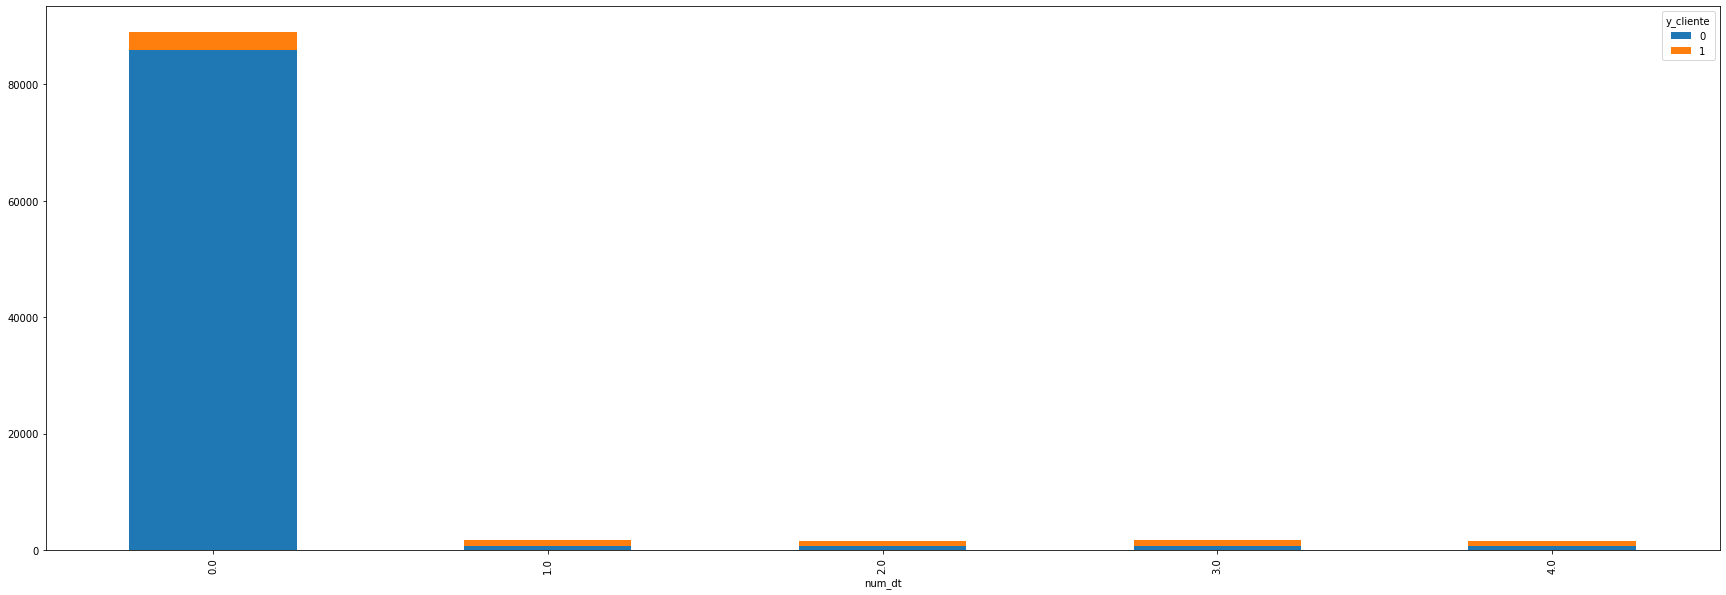

In [86]:
datos_diciembre.groupby(["num_dt", "y_cliente"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))
#Vemos que las lineas que no están impagas son las que en proporción menos abandono encontramos

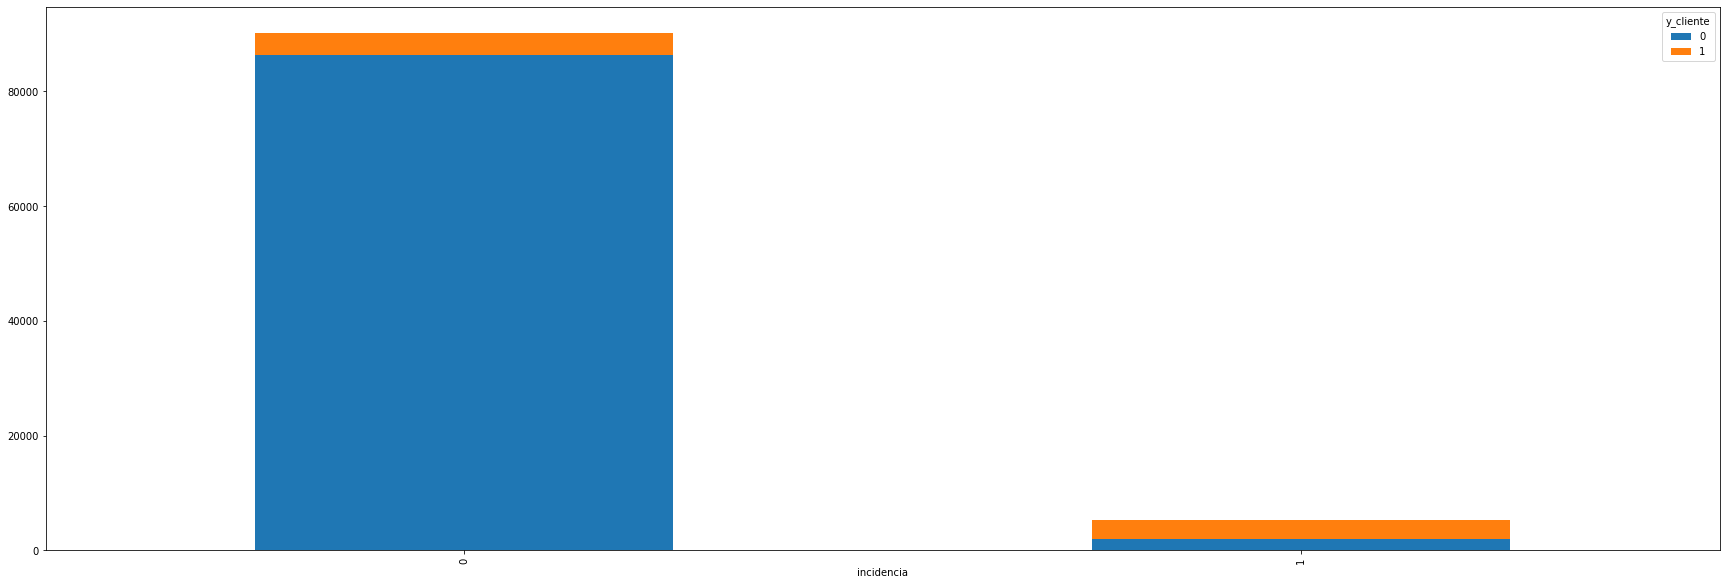

In [87]:
datos_diciembre.groupby(["incidencia", "y_cliente"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))
#Vemos que en proporción, la mayoria de las personas que dejan la empresa tienen incidencias realizadas

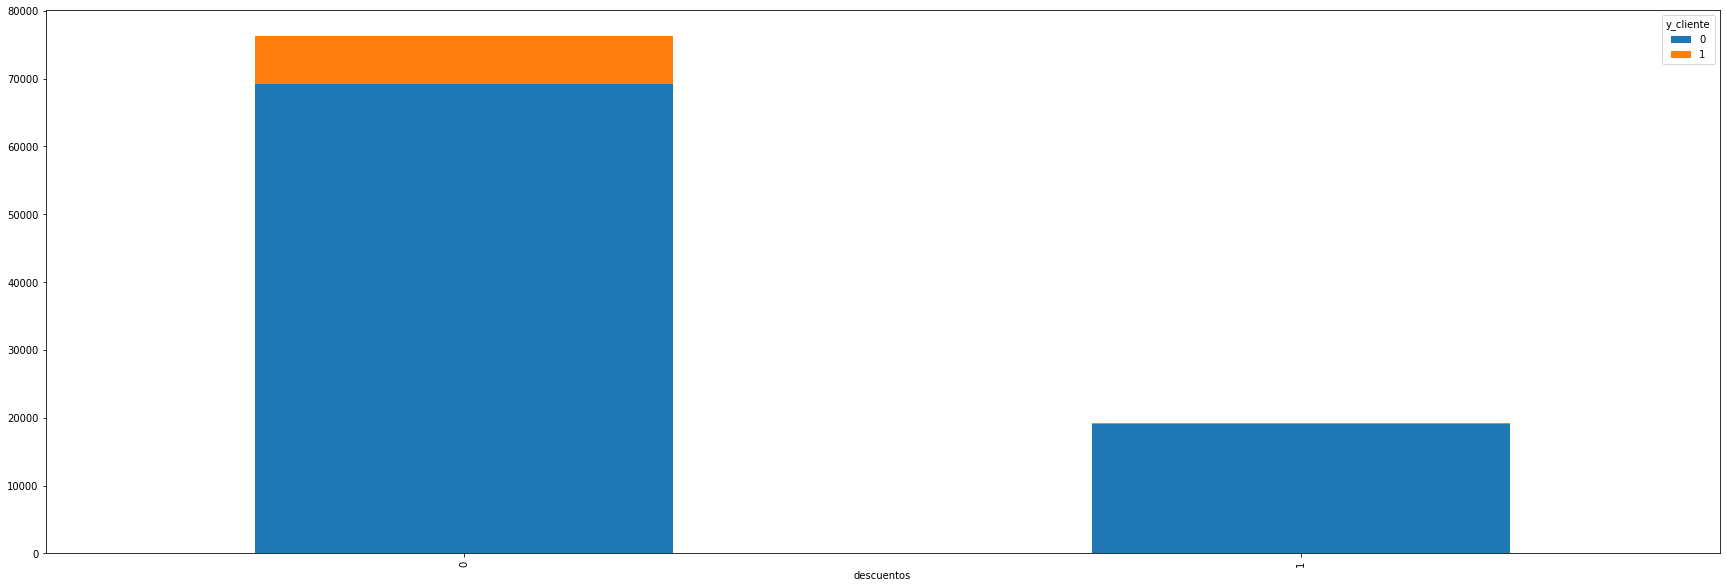

In [88]:
datos_diciembre.groupby(["descuentos", "y_cliente"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)) 
#Las personas que se marchan no tienen descuentos

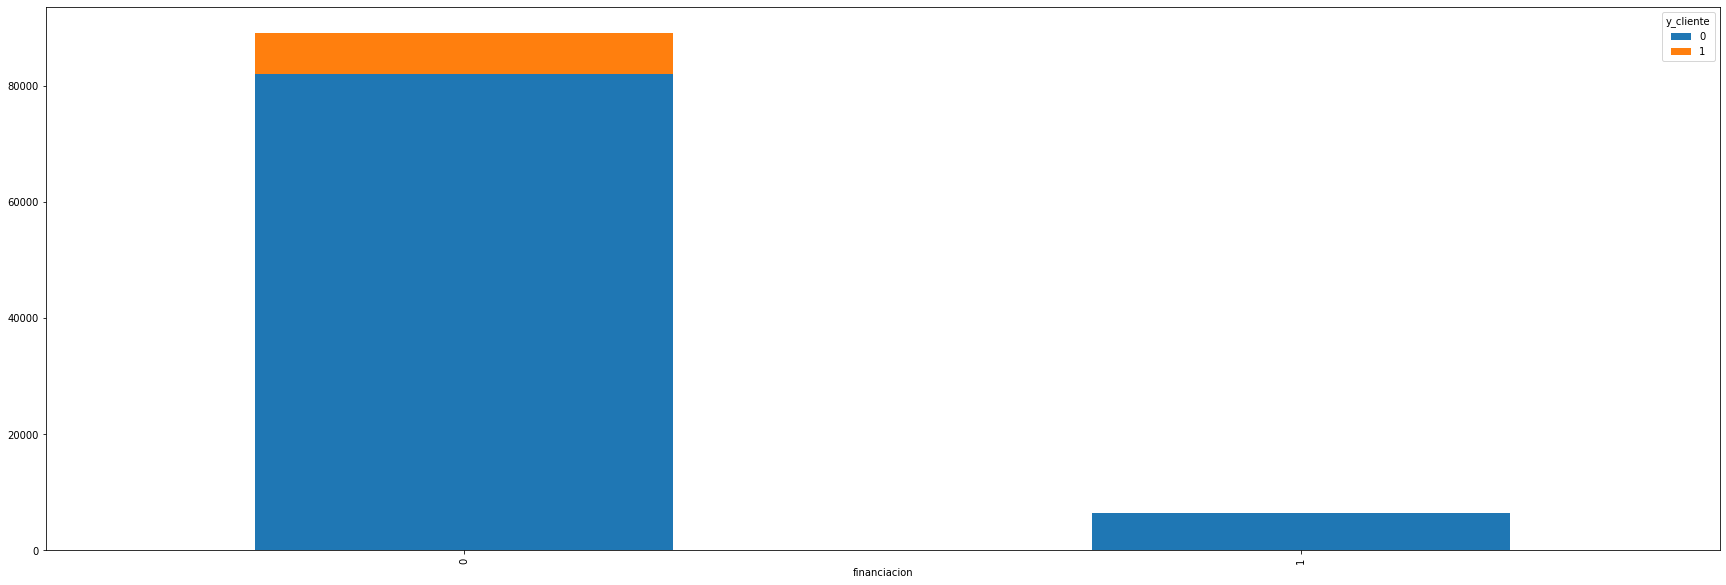

In [89]:
datos_diciembre.groupby(["financiacion", "y_cliente"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))
#Los clientes que se van, mayormente no tienen financiación

In [90]:
datos_diciembre.set_index('id',inplace=True)

### 3) Muestreo aleatorio estratificado 

Necesito estratificar para que la variable train y test tengan la misma proporción de clientes que se marchan y clientes que se quedan que la variable original.

In [91]:
#Obtengo mis datos sin la target
datos = datos_diciembre.copy(deep = True)
datos.drop('y_cliente',axis=1, inplace=True)

In [92]:
#Obtengo 'y_diciembre'
y_diciembre = datos_diciembre[['y_cliente']]

In [93]:
datos.shape

(95467, 18)

In [94]:
y_diciembre.shape

(95467, 1)

In [95]:
y_diciembre['y_cliente'].value_counts()

0    88382
1     7085
Name: y_cliente, dtype: int64

#### Multicolinealidad: Analisis VIF

In [96]:

# Borrado de la variable objetivo
datos_vif = datos_diciembre.copy(deep = True)
features = list(datos_vif.columns)
features.remove('y_cliente')
datos_vif = datos_vif[features]

for i in range(len(features)):
    var = features[i]
    fet = features[:]
    fet.remove(var)
    
    x = datos_vif[fet]
    y = datos[var]
    
    model = LinearRegression()
    model.fit(x, y)
    
    vif = 1 / (1 - model.score(x, y))
    
    print ('El valor del VIF para la variable', var, 'es:', vif)
    
    #Cuando VIF es mayor a 5 empiezo a estudiar multicolianidad
    #A partir de 10 ya se considera multicolinialidad extrema, y hay que eliminarla 

El valor del VIF para la variable edad es: 1.0003264020445897
El valor del VIF para la variable facturacion es: 1.3457519519789218
El valor del VIF para la variable provincia es: 1.0002303814393214
El valor del VIF para la variable num_lineas es: 1.2769922897966115
El valor del VIF para la variable num_dt es: 1.0000908663482382
El valor del VIF para la variable incidencia es: 1.000170148780911
El valor del VIF para la variable num_llamad_ent es: 1.000285252181377
El valor del VIF para la variable num_llamad_sal es: 1.0000810260162292
El valor del VIF para la variable mb_datos es: 1.0001063427975196
El valor del VIF para la variable seg_llamad_ent es: 1.000214715630035
El valor del VIF para la variable seg_llamad_sal es: 1.000180541086193
El valor del VIF para la variable conexion es: 1.6874693819707614
El valor del VIF para la variable vel_conexion es: 1.6874133873866068
El valor del VIF para la variable TV es: 1.0611482560603442
El valor del VIF para la variable financiacion es: 5.470

En los resultados podemos observar que hay dos variables (financiacion e imp_financ) que tienen valores mayores de 5. Voy a eliminar la que tiene el valor más alto y volveré a ejecutar el proceso.

In [97]:
features = list(datos_vif.columns)
features.remove('imp_financ')
datos_vif = datos_vif[features]

for i in range(len(features)):
    var = features[i]
    fet = features[:]
    fet.remove(var)
    
    x = datos_vif[fet]
    y = datos[var]
    
    model = LinearRegression()
    model.fit(x, y)
    
    vif = 1 / (1 - model.score(x, y))
    
    print ('El valor del VIF para la variable', var, 'es:', vif)

El valor del VIF para la variable edad es: 1.0003207598402097
El valor del VIF para la variable facturacion es: 1.3456375045205513
El valor del VIF para la variable provincia es: 1.0002232606130295
El valor del VIF para la variable num_lineas es: 1.2769616868596125
El valor del VIF para la variable num_dt es: 1.0000906195317727
El valor del VIF para la variable incidencia es: 1.0001537840614219
El valor del VIF para la variable num_llamad_ent es: 1.0002303361909903
El valor del VIF para la variable num_llamad_sal es: 1.0000805236368882
El valor del VIF para la variable mb_datos es: 1.0000920159555964
El valor del VIF para la variable seg_llamad_ent es: 1.0001798440023235
El valor del VIF para la variable seg_llamad_sal es: 1.0001783795186938
El valor del VIF para la variable conexion es: 1.687462442865545
El valor del VIF para la variable vel_conexion es: 1.687392367460439
El valor del VIF para la variable TV es: 1.0611462326480519
El valor del VIF para la variable financiacion es: 1.0

In [98]:
#Vemos la varianza de los datos
np.var(datos) 

edad               3.837972e+02
facturacion        1.239724e+04
provincia          2.083071e+02
num_lineas         1.179589e+00
num_dt             4.827403e-01
incidencia         5.180077e-02
num_llamad_ent     5.255084e+03
num_llamad_sal     8.479599e+02
mb_datos           5.240867e+07
seg_llamad_ent     3.321392e+07
seg_llamad_sal     3.321780e+07
conexion           2.499970e-01
vel_conexion       3.214092e+04
TV                 5.240972e-01
financiacion       6.229060e-02
imp_financ         3.780210e+01
descuentos         1.603805e-01
antiguedad_años    5.176277e+01
dtype: float64

In [99]:
## Escalado de variables: 
#Vamos a realizarlo ya que tenemos datos que se mueven entre rangos de valores pequeños, y otros tienen valores mucho más grande.
sc = StandardScaler()
datos_escalados = sc.fit_transform(datos)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(datos_escalados,
                                                    y_diciembre,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_diciembre)

In [101]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)  

### 4) Modelo
Tenemos que utilizar algún modelo de clasificacion, ya que necesesitamos saber la probabilidad de que algo ocurra o no. En este caso, es que el cliente deje la empresa (1) o que se quede (0) de un mes a otro.

Por ello vamos a trabajar con dos tipos de modelos para ver cuál es el mejor para este estudio (Regresion logistica y Random Forest)

#### Realizamos nuestros primeros modelos con todas las varibales

In [102]:
modelo_log_1 = LogisticRegression().fit(X_train, y_train)
y_pred_log_1 = modelo_log_1.predict(X_test)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[17400   277]
 [  200  1217]]
accuracy
0.9750183303655598
precision
0.8145917001338688
recall
0.8588567395906845
f1
0.8361387839230505
AUC
0.9215933299130094


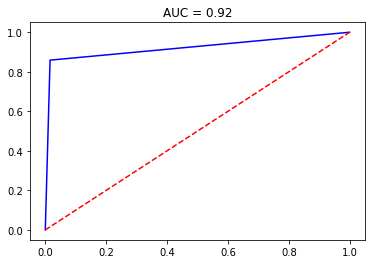

In [103]:
saca_metricas(y_test, y_pred_log_1)   #Tenemos que ver el accuranci, y el recall, ambos tienen que ser buenas. 

Feature: 0, Score: 0.01357
Feature: 1, Score: 0.03725
Feature: 2, Score: 0.01761
Feature: 3, Score: 0.03156
Feature: 4, Score: 1.62492
Feature: 5, Score: 1.32121
Feature: 6, Score: 0.03120
Feature: 7, Score: -0.01058
Feature: 8, Score: 0.03716
Feature: 9, Score: 0.01318
Feature: 10, Score: -0.01604
Feature: 11, Score: 0.01608
Feature: 12, Score: 0.04607
Feature: 13, Score: -0.00826
Feature: 14, Score: -1.59902
Feature: 15, Score: -0.68526
Feature: 16, Score: -4.75090
Feature: 17, Score: 0.00783


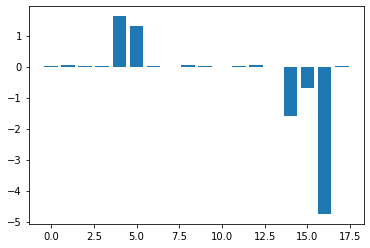

In [104]:
# get importance
importance = modelo_log_1.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [105]:
datos.columns.values

array(['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
       'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'conexion', 'vel_conexion',
       'TV', 'financiacion', 'imp_financ', 'descuentos',
       'antiguedad_años'], dtype=object)

Dentro de la improtancia de las variables nos interesan las que tienen un coeficiente positivo.

En este caso vemos que hay dos variables con bastante importancia: 'num_dt' e 'incidencia'

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


matriz de confusión
[[17368   309]
 [   10  1407]]
accuracy
0.9832931811040118
precision
0.8199300699300699
recall
0.9929428369795342
f1
0.898180657516757
AUC
0.9877312476462983


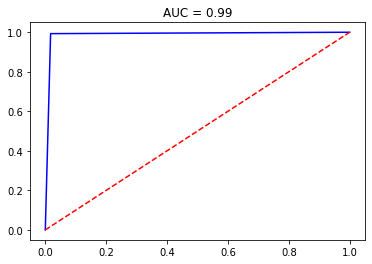

In [106]:
rf_classifier1 = RandomForestClassifier().fit(X_train, y_train)
y_pred1        = rf_classifier1.predict(X_test)
saca_metricas(y_test, y_pred1)

Feature: 0, Score: 0.01786
Feature: 1, Score: 0.02329
Feature: 2, Score: 0.01821
Feature: 3, Score: 0.00718
Feature: 4, Score: 0.36750
Feature: 5, Score: 0.29579
Feature: 6, Score: 0.02179
Feature: 7, Score: 0.01922
Feature: 8, Score: 0.02337
Feature: 9, Score: 0.02327
Feature: 10, Score: 0.02278
Feature: 11, Score: 0.00218
Feature: 12, Score: 0.01096
Feature: 13, Score: 0.00460
Feature: 14, Score: 0.01306
Feature: 15, Score: 0.01445
Feature: 16, Score: 0.09920
Feature: 17, Score: 0.01531


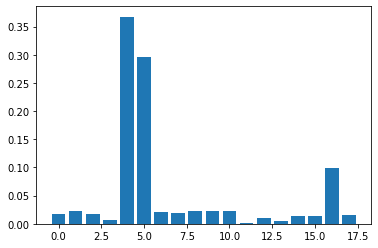

In [107]:
# Obtenemos la importancia de las variables 
importance = rf_classifier1.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Aquí vemos que 'descuentos' también es importante.

#### Resumen hasta el momento:
Ambos modelos, para ser los primeros son bastante buenos. El segundo es mejor, no solo porque el accurancy es más alto, sino porque la variación entre éste y el recall es menor. Además que la presición es un poco mejor.

In [108]:
# Ahora vamos a probar un modelo sin la variable 'financiacion' que tenia bastante multicolinealidad.
datos2 = datos.copy(deep = True)
datos2.drop('financiacion',axis=1, inplace=True)

In [109]:
## Escalado de variables: 
sc = StandardScaler()
datos_escalados2 = sc.fit_transform(datos2)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(datos_escalados2,
                                                    y_diciembre,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_diciembre)

In [111]:
modelo_log_2 = LogisticRegression().fit(X_train, y_train)
y_pred_log_2 = modelo_log_2.predict(X_test)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[17398   279]
 [  200  1217]]
accuracy
0.9749135854195035
precision
0.8135026737967914
recall
0.8588567395906845
f1
0.8355647099210436
AUC
0.9215367592279384


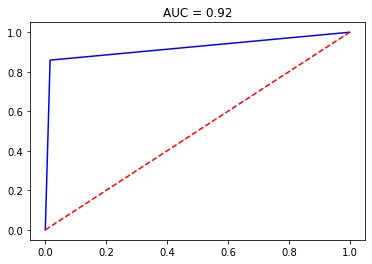

In [112]:
saca_metricas(y_test, y_pred_log_2)   #Tenemos que ver el accuranci, y el recall, ambos tienen que ser buenas. 

Feature: 0, Score: 0.01425
Feature: 1, Score: 0.03970
Feature: 2, Score: 0.01769
Feature: 3, Score: 0.03028
Feature: 4, Score: 1.61180
Feature: 5, Score: 1.31953
Feature: 6, Score: 0.03012
Feature: 7, Score: -0.01068
Feature: 8, Score: 0.03492
Feature: 9, Score: 0.01046
Feature: 10, Score: -0.01616
Feature: 11, Score: 0.01374
Feature: 12, Score: 0.04371
Feature: 13, Score: -0.01106
Feature: 14, Score: -3.30819
Feature: 15, Score: -4.72225
Feature: 16, Score: 0.00775


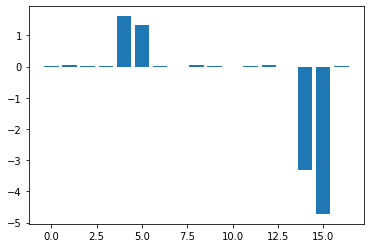

In [113]:
# get importance
importance = modelo_log_2.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


matriz de confusión
[[17367   310]
 [   10  1407]]
accuracy
0.9832408086309835
precision
0.819452533488643
recall
0.9929428369795342
f1
0.8978940650925334
AUC
0.9877029623037628


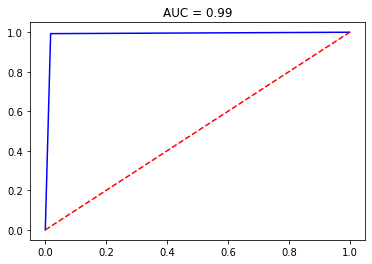

In [114]:
rf_classifier2 = RandomForestClassifier().fit(X_train, y_train)
y_pred2        = rf_classifier2.predict(X_test)
saca_metricas(y_test, y_pred2)

Feature: 0, Score: 0.01805
Feature: 1, Score: 0.02339
Feature: 2, Score: 0.01796
Feature: 3, Score: 0.00682
Feature: 4, Score: 0.36853
Feature: 5, Score: 0.29427
Feature: 6, Score: 0.02166
Feature: 7, Score: 0.01938
Feature: 8, Score: 0.02302
Feature: 9, Score: 0.02289
Feature: 10, Score: 0.02295
Feature: 11, Score: 0.00220
Feature: 12, Score: 0.01098
Feature: 13, Score: 0.00471
Feature: 14, Score: 0.03302
Feature: 15, Score: 0.09549
Feature: 16, Score: 0.01467


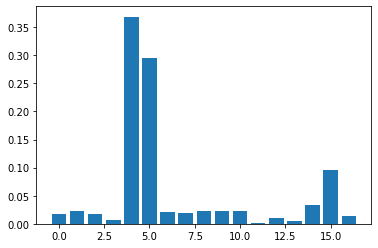

In [115]:
# Obtenemos la importancia de las variables 
importance = rf_classifier2.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

No encontramos cambios significativos

### 5)Mejora del modelo

#### Feature Engineering

In [116]:
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['%y_cliente'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%y_cliente']>0) & (proporcion['Conteo']>10)]
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%y_cliente'].values, linestyle='-', linewidth=2.0,color='g')
        plt.tight_layout()        
    
   

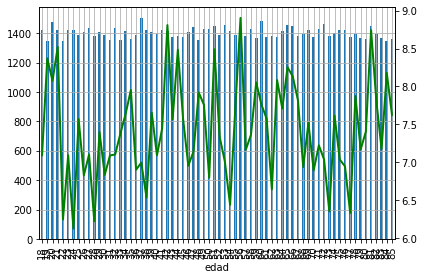

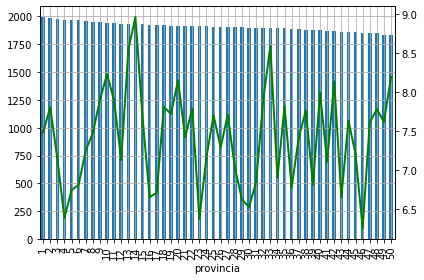

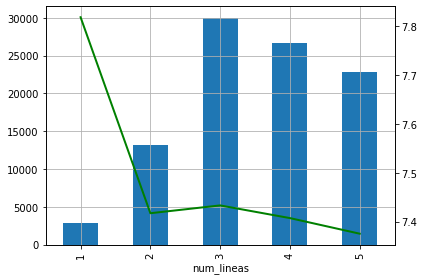

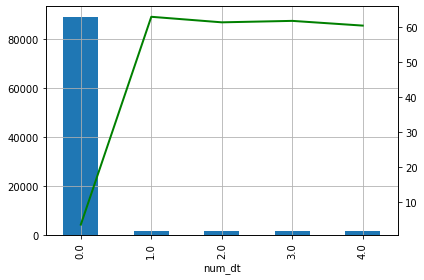

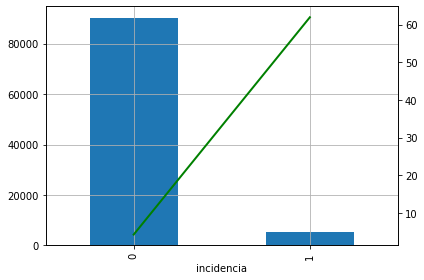

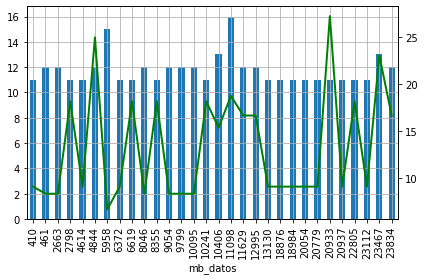

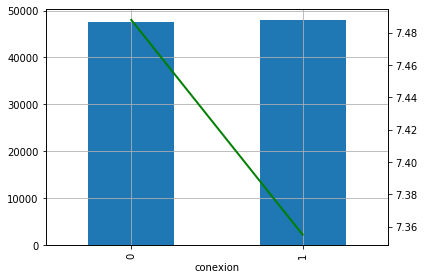

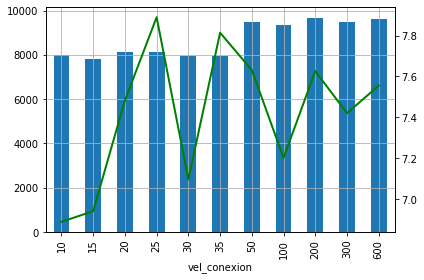

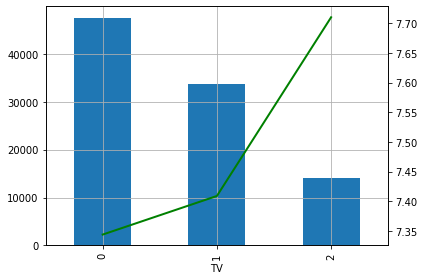

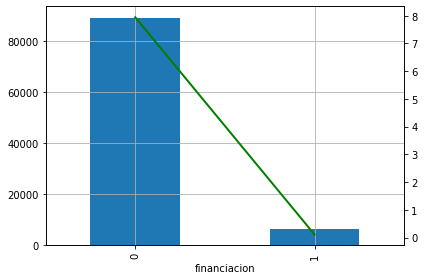

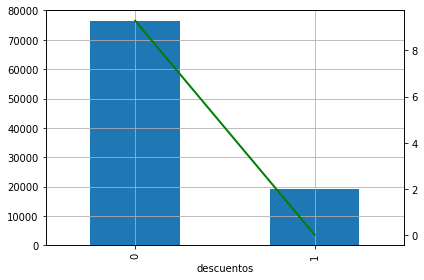

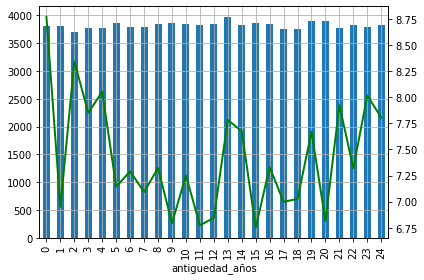

In [117]:
for i in datos_diciembre.columns:
    proporciones_final (i, 'y_cliente', datos_diciembre)


In [118]:
datos_diciembre2 = datos_diciembre.copy(deep = True)
datos_diciembre2

,edad,facturacion,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,y_cliente,antiguedad_años
id,,,,,,,,,,,,,,,,,,,
1,63,216.028109,40,5,0.0,0,110,79,10897,12806,13751,0,50,0,0,0.000000,0,0,1
2,84,255.830842,49,3,0.0,0,189,89,18657,6499,10862,0,600,0,0,0.000000,1,0,2
3,66,135.768153,36,4,0.0,0,129,30,15511,17013,16743,1,35,0,0,0.000000,1,0,18
4,69,255.658527,41,4,0.0,0,51,52,12670,3393,6771,0,200,1,0,0.000000,0,0,4
5,25,22.302845,22,2,2.0,0,183,3,23756,18436,4485,1,10,0,0,0.000000,0,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,65,173.741667,6,5,0.0,0,121,98,13403,6197,6853,1,35,1,1,23.138779,0,0,0
99996,36,215.890326,38,3,0.0,0,98,13,5291,3684,1667,1,30,0,0,0.000000,0,0,6
99997,68,285.890750,4,5,0.0,0,226,20,20002,572,5679,0,200,0,1,14.616422,0,0,16


In [119]:
## NUM_DT (observamos que la mayoria de la gente que se va tiene alguna linea impaga)
datos_diciembre2['num_dt_nueva'] = datos_diciembre2['num_dt'].apply(lambda x: 0 if x<=1 else 1)

In [120]:
## NUM_LINEAS (realizamos una variable con 3 rangos de número de lineasa y 3 variables con esos mismos rangos)
datos_diciembre2['num_lineas_bajo'] = datos_diciembre2['num_lineas'].apply(lambda x: 1 if x<=2 else 0)
datos_diciembre2['num_lineas_medio'] = datos_diciembre2['num_lineas'].apply(lambda x: 1 if x>2 & x<5 else 0)
datos_diciembre2['num_lineas_alto'] = datos_diciembre2['num_lineas'].apply(lambda x: 1 if x>=5 else 0)
datos_diciembre2['num_lineas_nueva'] = datos_diciembre2['num_lineas'].apply(lambda x: 0 if x<=2 else (1 if x>2 and x<5 else(2)))  

In [121]:
## ANTIGUEDAD_AÑOS (realizamos una variable con 3 rangos de antiguedad y 3 variables con esos mismos rangos)
datos_diciembre2['antiguedad_años_bajo'] = datos_diciembre2['antiguedad_años'].apply(lambda x: 1 if x<=8 else 0)
datos_diciembre2['antiguedad_años_medio'] = datos_diciembre2['antiguedad_años'].apply(lambda x: 1 if x>8 & x<16 else 0)
datos_diciembre2['antiguedad_años_alto'] = datos_diciembre2['antiguedad_años'].apply(lambda x: 1 if x>=16 else 0)
datos_diciembre2['antiguedad_años_nueva'] = datos_diciembre2['antiguedad_años'].apply(lambda x: 0 if x<=8 else (1 if x>8 and x<16 else(2)))  

In [122]:
## EDAD (realizamos una variable con 3 rangos de edad), los datos van de 18 a 85 años. Vamos a hacer 3 grupos
datos_diciembre2['edad_bajo'] = datos_diciembre2['edad'].apply(lambda x: 1 if x<=40 else 0)
datos_diciembre2['edad_medio'] = datos_diciembre2['edad'].apply(lambda x: 1 if x>40 & x<62 else 0)
datos_diciembre2['edad_alto'] = datos_diciembre2['edad'].apply(lambda x: 1 if x>=62 else 0)

In [123]:
corr =  abs(datos_diciembre2.corr())
corr[['y_cliente']].sort_values(by = 'y_cliente',ascending = False).style.background_gradient()

,y_cliente
y_cliente,1.000000
num_dt,0.504867
incidencia,0.500885
num_dt_nueva,0.475903
descuentos,0.141447
financiacion,0.074597
imp_financ,0.067626
antiguedad_años_medio,0.006991
antiguedad_años_bajo,0.006303
num_llamad_ent,0.006130


Observamos que nuestras variables más importante siguen siendo las mismas. Sin embago vemos que algunas variables como 'antiguedad' y 'edad' con las nuevas transformaciones han mejorado su correlación y han pasado a tener mayor importancia que antes.

In [124]:
# Probamos un nuevo modelo con estas trasnformaciones
datos_diciembre2.drop('y_cliente',axis=1, inplace=True)

In [125]:
# Escalado de variables
sc = StandardScaler()
datos_diciembre2_escalados = sc.fit_transform(datos_diciembre2)

X_train, X_test, y_train, y_test = train_test_split(datos_diciembre2_escalados,
                                                    y_diciembre,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_diciembre)

In [126]:
#Modelo con todas las varibales
modelo_log_3 = LogisticRegression().fit(X_train, y_train)
y_pred_log_3 = modelo_log_3.predict(X_test)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[17443   234]
 [  362  1055]]
accuracy
0.9687860060752068
precision
0.8184639255236618
recall
0.744530698659139
f1
0.7797487065779749
AUC
0.8656465791762631


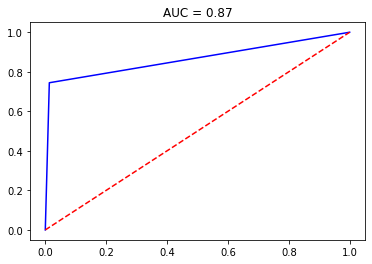

In [127]:
saca_metricas(y_test, y_pred_log_3)   #Tenemos que ver el accuranci, y el recall, ambos tienen que ser buenas. 

Este modelo con más variables ha empeorado.

Feature: 0, Score: 0.08636
Feature: 1, Score: 0.03165
Feature: 2, Score: 0.00567
Feature: 3, Score: -0.04857
Feature: 4, Score: 2.40321
Feature: 5, Score: 1.34262
Feature: 6, Score: 0.03395
Feature: 7, Score: -0.00732
Feature: 8, Score: 0.03133
Feature: 9, Score: 0.01782
Feature: 10, Score: -0.01659
Feature: 11, Score: 0.00443
Feature: 12, Score: 0.03779
Feature: 13, Score: -0.00914
Feature: 14, Score: -1.93361
Feature: 15, Score: -0.69973
Feature: 16, Score: -5.40492
Feature: 17, Score: 0.11152
Feature: 18, Score: -0.59021
Feature: 19, Score: -0.09402
Feature: 20, Score: -0.09030
Feature: 21, Score: 0.00571
Feature: 22, Score: 0.05929
Feature: 23, Score: 0.05755
Feature: 24, Score: -0.01859
Feature: 25, Score: -0.01650
Feature: 26, Score: -0.04192
Feature: 27, Score: 0.02530
Feature: 28, Score: 0.04536
Feature: 29, Score: -0.07086


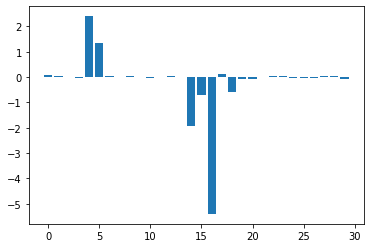

In [128]:
# get importance
importance = modelo_log_3.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Las variable más explicativas continuan siendo las mismas.

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


matriz de confusión
[[17367   310]
 [    8  1409]]
accuracy
0.9833455535770399
precision
0.8196625945317044
recall
0.9943542695836274
f1
0.8985969387755102
AUC
0.9884086786058093


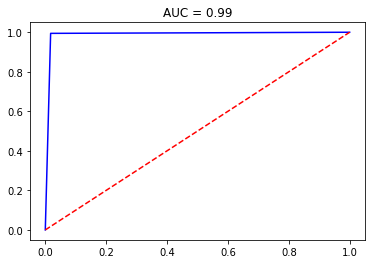

In [129]:
rf_classifier3 = RandomForestClassifier().fit(X_train, y_train)
y_pred3        = rf_classifier3.predict(X_test)
saca_metricas(y_test, y_pred3)

Feature: 0, Score: 0.01749
Feature: 1, Score: 0.02283
Feature: 2, Score: 0.01823
Feature: 3, Score: 0.00533
Feature: 4, Score: 0.24217
Feature: 5, Score: 0.29453
Feature: 6, Score: 0.02177
Feature: 7, Score: 0.01913
Feature: 8, Score: 0.02245
Feature: 9, Score: 0.02268
Feature: 10, Score: 0.02271
Feature: 11, Score: 0.00249
Feature: 12, Score: 0.01153
Feature: 13, Score: 0.00494
Feature: 14, Score: 0.01519
Feature: 15, Score: 0.01292
Feature: 16, Score: 0.09931
Feature: 17, Score: 0.01384
Feature: 18, Score: 0.11038
Feature: 19, Score: 0.00112
Feature: 20, Score: 0.00120
Feature: 21, Score: 0.00169
Feature: 22, Score: 0.00264
Feature: 23, Score: 0.00166
Feature: 24, Score: 0.00132
Feature: 25, Score: 0.00184
Feature: 26, Score: 0.00308
Feature: 27, Score: 0.00216
Feature: 28, Score: 0.00113
Feature: 29, Score: 0.00225


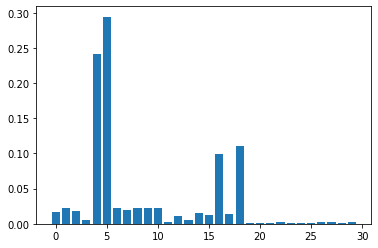

In [130]:
# Obtenemos la importancia de las variables 
importance = rf_classifier3.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [131]:
datos_diciembre2.columns.values

array(['edad', 'facturacion', 'provincia', 'num_lineas', 'num_dt',
       'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'conexion', 'vel_conexion',
       'TV', 'financiacion', 'imp_financ', 'descuentos',
       'antiguedad_años', 'num_dt_nueva', 'num_lineas_bajo',
       'num_lineas_medio', 'num_lineas_alto', 'num_lineas_nueva',
       'antiguedad_años_bajo', 'antiguedad_años_medio',
       'antiguedad_años_alto', 'antiguedad_años_nueva', 'edad_bajo',
       'edad_medio', 'edad_alto'], dtype=object)

No encontramos cambios significativos, pero vemos que las variables que son más explicativas siguen siendo las mismas. Se ha sumado 'num_dt_nueva', pero está relacionada con 'num_dt'.

#### Resumen hasta el momento:
No hemos realizado una mejora a traves con este proceso, ya que las variables explicativas siguen siendo las mismas.

#### Análisis univariante 

In [132]:
target = y_diciembre
features = list(datos_diciembre2.columns)

x = datos_diciembre2[features]
y = y_diciembre

In [133]:
S_chi5 = SelectKBest(chi2, k = 5) #k = cantidad de variables que quiero que me saque, es chi2 porque es un modelo de regresion.
X_chi5 = S_chi5.fit_transform(x, y)

print ("Listado de variables ", np.asarray(list(x))[S_chi5.get_support()])

Listado de variables  ['num_dt' 'incidencia' 'imp_financ' 'descuentos' 'num_dt_nueva']


Observamos que las varibales seleccionadas a través de éste método son las mismás que elegimos anteriormente según la importancia que vimos en los modelos. 

In [134]:
variables_importantes = datos_diciembre2.copy(deep = True)
seleccion = ['num_dt', 'incidencia', 'descuentos','imp_financ'] # no selecciono 'num_dt_nueva' ya que tienen menor correlación con nuestra Y que 'num_dt'
variables_importantes = variables_importantes[seleccion]


In [135]:
variables_importantes

,num_dt,incidencia,descuentos,imp_financ
id,,,,
1,0.0,0,0,0.000000
2,0.0,0,1,0.000000
3,0.0,0,1,0.000000
4,0.0,0,0,0.000000
5,2.0,0,0,0.000000
...,...,...,...,...
99995,0.0,0,0,23.138779
99996,0.0,0,0,0.000000
99997,0.0,0,0,14.616422


In [136]:
# Escalado de variables
sc = StandardScaler()
variables_importantes_escalados = sc.fit_transform(variables_importantes)

X_train, X_test, y_train, y_test = train_test_split(variables_importantes_escalados,
                                                    y_diciembre,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_diciembre)

In [137]:
#Modelo con todas las varibales
modelo_log_4 = LogisticRegression().fit(X_train, y_train)
y_pred_log_4 = modelo_log_4.predict(X_test)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[17398   279]
 [  200  1217]]
accuracy
0.9749135854195035
precision
0.8135026737967914
recall
0.8588567395906845
f1
0.8355647099210436
AUC
0.9215367592279384


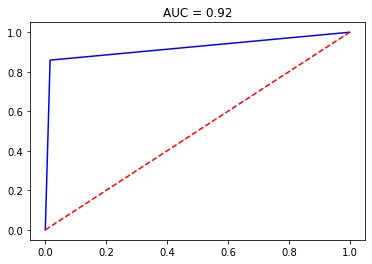

In [138]:
saca_metricas(y_test, y_pred_log_4)  

Podemos observar que éste modelo, tiene casi las mismas métricas que el primero, pero con la diferencia de que tiene solo 4 variables. En este sentido podemos decir que es mucho mejor.

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


matriz de confusión
[[17364   313]
 [    8  1409]]
accuracy
0.9831884361579554
precision
0.8182346109175378
recall
0.9943542695836274
f1
0.8977381331634279
AUC
0.9883238225782028


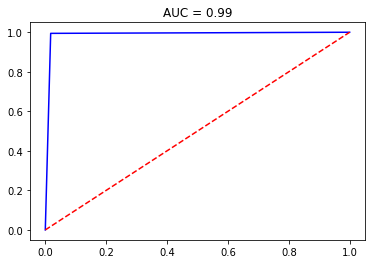

In [139]:
rf_classifier = RandomForestClassifier().fit(X_train, y_train)
y_pred       = rf_classifier.predict(X_test)
saca_metricas(y_test, y_pred)

Podemos observar que éste modelo, tiene casi las mismas métricas que los anteriores, pero con la diferencia de que tiene solo 4 variables. 
Hay que tener encuenta que tiene una precisión un poco menor, pero personamente creo que este modelo es el ganandor, ya que aunque pierdo un poco en esa métrica, gano en la reducción de parámetros.

#### Validación cruzada

In [140]:
results = cross_val_score(estimator=rf_classifier, X=X_train, y=y_train, cv=5)

/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/geraldinedaianacacciatore/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/geraldinedaianacacciatore/o

In [141]:
results # Vemos que son todos bastantes parecidos, eso es bueno.

array([0.98527005, 0.98304419, 0.98527005, 0.98245384, 0.98284667])

In [142]:
print(results.mean())

0.9837769597448206


In [143]:
print(results.std())  #Vemos que la desviación típica tambien es baja. 

0.0012338285550918763


Finalmente decido que el modelo rf_classifier4 es el mejor de todos los realizados

### 6) Predicción de los clientes de la cosecha de enero que más probabilidad tienen de cambiarse de operadora

Realizamos el mismo pre procesado de datos que hicimos en diciembre, pero en los datos de enero.

Hay que tener en cuenta que el  FE no se va a realizar ya que en el modelo ganador no utilizamos ninguna variable creada en este paso.

#### Análisis de NA's (Enero)

In [144]:
#Nos fijamos en qué variables tenemos NA's para ver cómo completarlo
datos_enero.isnull().sum()

id                    0
edad                  0
facturacion           0
antiguedad            0
provincia             0
num_lineas            0
num_dt            90097
incidencia        90720
num_llamad_ent        0
num_llamad_sal        0
mb_datos              0
seg_llamad_ent        0
seg_llamad_sal        0
conexion              0
vel_conexion          0
TV                    0
financiacion      86045
imp_financ        86045
descuentos        72673
dtype: int64

Vemos que tenemos que arreglar 5 variables

In [145]:
#1) 'num_dt' Son las lineas que están impagas, en caso de estár en blanco vamos a completarlos por un 0.
datos_enero['num_dt'] = datos_enero['num_dt'].replace(np.nan, 0)

In [146]:
#2) 'incidencia' Si está en blanco es porque el cliente no tiene ninguna incidencia
datos_enero['incidencia'] = datos_enero['incidencia'].replace(np.nan, 'NO')

In [147]:
#3) 'financiacion' Si está en blanco e sorque el cliente no tienen ninguna financiacion
datos_enero['financiacion'] = datos_enero['financiacion'].replace(np.nan, 'NO')

In [148]:
#4) 'imp_financ ' Si está en blanco e sorque el cliente no tienen ninguna financiacion y por lo tanto no tienen ningún importe financiado
datos_enero['imp_financ'] = datos_enero['imp_financ'].replace(np.nan, 0)

In [149]:
#5) 'descuentos ' Si está en blanco es porque el cliente no tiene ningún tipo de descuente
datos_enero['descuentos'] = datos_enero['descuentos'].replace(np.nan, 0)

In [150]:
#Comprobamos que no temos ningún NA
datos_enero.isnull().sum()

id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
conexion          0
vel_conexion      0
TV                0
financiacion      0
imp_financ        0
descuentos        0
dtype: int64

#### --- Análsis de las variables numércias --- (Enero)

In [151]:
#Veo el tipo de datos que tengo 
datos_enero.dtypes #Tenemos 11 variables numéricas

id                  int64
edad                int64
facturacion       float64
antiguedad         object
provincia          object
num_lineas          int64
num_dt            float64
incidencia         object
num_llamad_ent      int64
num_llamad_sal      int64
mb_datos            int64
seg_llamad_ent      int64
seg_llamad_sal      int64
conexion           object
vel_conexion       object
TV                 object
financiacion       object
imp_financ        float64
descuentos         object
dtype: object

In [152]:
#Vemos las variables numéricas.
datos_enero.describe() # -> no encontramos nada raro

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ
count,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000,92711.000000
mean,49997.623626,51.429237,207.488700,3.560214,0.071318,125.109836,49.858960,12510.190495,9985.382781,10030.443960,1.601433
std,28863.150364,19.585913,111.239476,1.085810,0.459214,72.421075,29.208549,7217.671483,5774.903324,5786.754197,6.366161
min,1.000000,18.000000,15.000439,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24963.500000,34.000000,111.368385,3.000000,0.000000,62.000000,25.000000,6232.500000,4960.000000,5010.000000,0.000000
50%,49999.000000,51.000000,207.089366,4.000000,0.000000,125.000000,50.000000,12526.000000,9998.000000,10037.000000,0.000000
75%,74990.500000,68.000000,304.349361,4.000000,0.000000,188.000000,75.000000,18742.000000,14981.000000,15036.000000,0.000000
max,100000.000000,85.000000,399.998433,5.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.991954


In [153]:
#Comprobamos que no tenemos ID repetidos
datos_enero['id'].value_counts() 

2047     1
13011    1
725      1
6870     1
4823     1
        ..
21920    1
23969    1
17826    1
19875    1
2049     1
Name: id, Length: 92711, dtype: int64

#### --- Análsis de las variables no numércias --- (Dicimebre)

A tratar: antiguedad, provincia, incidencia, conexion, vel_conexion, TV, financiacion, descuentos

1) ANTIGUEDAD

In [154]:
len(datos_enero['antiguedad'].unique())

92237

In [155]:
datos_enero['antiguedad'].value_counts() 
# Vemos que algunas fechas se repiten tres veces

01/07/2020 10:37 PM    3
01/14/2020 05:08 PM    3
01/07/2020 03:55 PM    3
01/19/2020 04:57 PM    3
01/25/2020 12:51 PM    3
                      ..
08/08/2017 04:56 PM    1
01/23/2020 06:10 AM    1
01/01/1998 08:56 PM    1
07/29/2001 02:39 AM    1
08/27/2008 01:48 PM    1
Name: antiguedad, Length: 92237, dtype: int64

In [156]:
# Paso la fecha a formato datatime:
datos_enero['antiguedad'] = pd.to_datetime(datos_enero['antiguedad'])

Vamos a crear una nueva variable que me diga la antiguedad en años del cliente

In [157]:
#Creo una columna que contenga el año de ingreso a la compañia para despues calcular su antiguedad en años
datos_enero['año_ingreso'] = pd.DatetimeIndex(datos_enero['antiguedad']).year
datos_enero.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,año_ingreso
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,0.0,NO,95,19,6525,7634,18520,FIBRA,50MB,tv-futbol,NO,0.0,0,2018
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,0.0,NO,44,36,14471,14541,8016,FIBRA,600MB,tv-futbol,NO,0.0,SI,2017
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,0.0,NO,94,27,1428,5248,7106,ADSL,35MB,tv-futbol,NO,0.0,SI,2001
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,0.0,NO,186,20,20083,7372,5052,FIBRA,200MB,tv-familiar,NO,0.0,0,2015
4,6,51,99.348645,1997-11-04 11:43:00,Huelva,4,0.0,NO,37,32,19078,5009,8686,FIBRA,200MB,tv-futbol,NO,0.0,0,1997


In [158]:
# Creo una variable que me dice la antifuedad en años
datos_enero['antiguedad_años'] = 2020-datos_enero['año_ingreso']
datos_enero.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_ent,seg_llamad_sal,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,año_ingreso,antiguedad_años
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,0.0,NO,95,19,...,7634,18520,FIBRA,50MB,tv-futbol,NO,0.0,0,2018,2
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,0.0,NO,44,36,...,14541,8016,FIBRA,600MB,tv-futbol,NO,0.0,SI,2017,3
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,0.0,NO,94,27,...,5248,7106,ADSL,35MB,tv-futbol,NO,0.0,SI,2001,19
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,0.0,NO,186,20,...,7372,5052,FIBRA,200MB,tv-familiar,NO,0.0,0,2015,5
4,6,51,99.348645,1997-11-04 11:43:00,Huelva,4,0.0,NO,37,32,...,5009,8686,FIBRA,200MB,tv-futbol,NO,0.0,0,1997,23


In [159]:
datos_enero['antiguedad_años'].value_counts() 

0     4329
14    3650
21    3637
10    3595
16    3591
20    3588
13    3580
6     3575
12    3565
17    3565
9     3557
11    3556
23    3545
15    3537
2     3534
8     3524
25    3520
7     3510
18    3495
24    3488
19    3480
22    3475
1     3475
4     3474
5     3471
3     3395
Name: antiguedad_años, dtype: int64

In [160]:
datos_enero.drop('año_ingreso',axis=1, inplace=True)

In [161]:
datos_enero.drop('antiguedad',axis=1, inplace=True)

2) PROVINCIA

In [162]:
len(datos_enero['provincia'].unique())

50

In [163]:
datos_enero['provincia'].value_counts() 

Valencia                  1941
Asturias                  1934
Murcia                    1931
Navarra                   1930
Zaragoza                  1927
Málaga                    1924
Alicante                  1895
Orense                    1891
Guipúzcoa                 1886
Zamora                    1879
Huelva                    1878
Córdoba                   1875
Granada                   1874
Cáceres                   1868
La Coruña                 1867
Santa Cruz de Tenerife    1866
Burgos                    1866
Sevilla                   1865
Soria                     1865
Islas Baleares            1864
Almería                   1863
Cádiz                     1862
Álava                     1859
Tarragona                 1857
Badajoz                   1856
Salamanca                 1854
Castellón                 1854
Barcelona                 1852
Valladolid                1850
Segovia                   1850
Madrid                    1849
Ciudad Real               1848
Lugo    

In [164]:
# Esto podriamos haberlo realizado con un Label Encode, pero personalmente preferí realizarlo manualmente

datos_enero.provincia.replace(('Zaragoza','Navarra','Málaga','Asturias','Valencia',
                                   'Murcia','Orense','Alicante','Córdoba','Cáceres',
                                   'Burgos','Guipúzcoa','Álava','Valladolid','Sevilla',
                                   'Huelva', 'Santa Cruz de Tenerife', 'La Coruña', 'Segovia','Castellón',
                                   'Granada','Tarragona','Zamora','Almería','Soria',
                                   'Madrid','Pontevedra','Ciudad Real','Cádiz','Badajoz',
                                   'Islas Baleares','Barcelona','Teruel','Salamanca','Ávila',
                                   'Albacete','Jaén','Guadalajara','Lérida','La Rioja',
                                   'Lugo','Toledo','Gerona','Las Palmas','Palencia',
                                   'Cuenca','Cantabria','León','Vizcaya','Huesca'
                                   ),
                                  (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                                  21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
                                  38,39,40,41,42,43,44,45,46,47,48,49,50),inplace=True)

3) INCIDENCIA

In [165]:
len(datos_enero['incidencia'].unique())

2

In [166]:
datos_enero['incidencia'].value_counts()

NO    90720
SI     1991
Name: incidencia, dtype: int64

In [167]:
datos_enero['incidencia'] = datos_enero['incidencia'].map({'SI':1,'NO':0})

In [168]:
datos_enero['incidencia'].value_counts()

0    90720
1     1991
Name: incidencia, dtype: int64

4) CONEXIÓN

In [169]:
len(datos_enero['conexion'].unique())

2

In [170]:
datos_enero['conexion'].value_counts()

ADSL     46591
FIBRA    46120
Name: conexion, dtype: int64

In [171]:
#ADSL = 1, FIBRA = 0
datos_enero['conexion'] = datos_enero['conexion'].map({'ADSL':1,'FIBRA':0})

In [172]:
datos_enero['conexion'].value_counts()

1    46591
0    46120
Name: conexion, dtype: int64

5) VELOCIDAD

In [173]:
datos_enero['vel_conexion'].value_counts()

200MB    9342
600MB    9300
300MB    9212
50MB     9167
100MB    9099
20MB     7882
25MB     7840
10MB     7807
30MB     7761
35MB     7674
15MB     7627
Name: vel_conexion, dtype: int64

In [174]:
datos_enero.vel_conexion = datos_enero.vel_conexion.map(dejar_solo_cifras)

In [175]:
datos_enero['vel_conexion'].value_counts()

200    9342
600    9300
300    9212
50     9167
100    9099
20     7882
25     7840
10     7807
30     7761
35     7674
15     7627
Name: vel_conexion, dtype: int64

In [176]:
datos_enero['vel_conexion'] = datos_enero['vel_conexion'].astype(int)

6) TV

In [177]:
len(datos_enero['TV'].unique())

3

In [178]:
datos_enero['TV'].value_counts()

tv-futbol      46191
tv-familiar    32822
tv-total       13698
Name: TV, dtype: int64

In [179]:
#tv-futbol:0, tv-familiar:1, tv-total:2
datos_enero['TV'] = datos_enero['TV'].map({'tv-futbol':0,'tv-familiar':1, 'tv-total':2})

In [180]:
datos_enero['TV'].value_counts()

0    46191
1    32822
2    13698
Name: TV, dtype: int64

7) FINANCIACIÓN

In [181]:
len(datos_enero['financiacion'].unique())

2

In [182]:
datos_enero['financiacion'].value_counts()

NO    86045
SI     6666
Name: financiacion, dtype: int64

In [183]:
datos_enero['financiacion'] = datos_enero['financiacion'].map({'SI':1,'NO':0})

In [184]:
datos_enero['financiacion'].value_counts()

0    86045
1     6666
Name: financiacion, dtype: int64

8) DESCUENTOS

In [185]:
len(datos_enero['descuentos'].unique())

2

In [186]:
datos_enero['descuentos'].value_counts()

0     72673
SI    20038
Name: descuentos, dtype: int64

In [187]:
datos_enero['descuentos'] = datos_enero['descuentos'].map({'SI':1,0:0})

In [188]:
datos_enero['descuentos'].value_counts()

0    72673
1    20038
Name: descuentos, dtype: int64

In [189]:
#Comrpobamos que todo sea numérico
datos_enero.dtypes

id                   int64
edad                 int64
facturacion        float64
provincia            int64
num_lineas           int64
num_dt             float64
incidencia           int64
num_llamad_ent       int64
num_llamad_sal       int64
mb_datos             int64
seg_llamad_ent       int64
seg_llamad_sal       int64
conexion             int64
vel_conexion         int64
TV                   int64
financiacion         int64
imp_financ         float64
descuentos           int64
antiguedad_años      int64
dtype: object

In [190]:
datos_enero.set_index('id',inplace=True)

In [191]:
#Seleccionamos las mismas variables que en diciembre
variables_importantes_enero = datos_enero.copy(deep = True)
variables_importantes_enero = variables_importantes_enero[seleccion]

In [192]:
#Escalamos los datos al igual que en diciembre
sc2 = StandardScaler()
datos_escalados_enero = sc2.fit_transform(variables_importantes_enero)

In [193]:
datos_escalados_enero

array([[-0.15530624, -0.14814401, -0.52509834, -0.25155529],
       [-0.15530624, -0.14814401,  1.9044052 , -0.25155529],
       [-0.15530624, -0.14814401,  1.9044052 , -0.25155529],
       ...,
       [-0.15530624, -0.14814401, -0.52509834, -0.25155529],
       [-0.15530624, -0.14814401, -0.52509834, -0.25155529],
       [-0.15530624, -0.14814401,  1.9044052 , -0.25155529]])

In [194]:
datos_escalados_enero = pd.DataFrame(datos_escalados_enero)

In [195]:
datos_escalados_enero

,0,1,2,3
0,-0.155306,-0.148144,-0.525098,-0.251555
1,-0.155306,-0.148144,1.904405,-0.251555
2,-0.155306,-0.148144,1.904405,-0.251555
3,-0.155306,-0.148144,-0.525098,-0.251555
4,-0.155306,-0.148144,-0.525098,-0.251555
...,...,...,...,...
92706,-0.155306,-0.148144,-0.525098,-0.251555
92707,-0.155306,-0.148144,-0.525098,2.044413
92708,-0.155306,-0.148144,-0.525098,-0.251555
92709,-0.155306,-0.148144,-0.525098,-0.251555


Guardamos el modelo ganador como un objeto de python (pickle) para después volver a usarlo para predecir futuros datos.
En éste caso lo usamos para predecir la cosecha de enero, pero se podria utilizar para los siguientes meses.

In [196]:
pkl_filename = "modelo1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_classifier, file)

In [197]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [198]:
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)

Test score: 98.32 %


In [199]:
modelo_proba = rf_classifier.predict_proba(datos_escalados_enero)[:,1] #Esto es lo que saca la tabla, el resto ordena 

In [200]:
modelo_proba = (pd.DataFrame(modelo_proba,columns=['probabilidad'],index=datos_escalados_enero.index))


In [201]:
modelo_proba.sort_values(by=['probabilidad'],ascending=False,axis=0,inplace=True)

In [202]:
modelo_proba

,probabilidad
54736,0.838203
55216,0.838203
14033,0.838203
55585,0.838203
27402,0.838203
...,...
50570,0.000000
4661,0.000000
58337,0.000000
58336,0.000000


In [203]:
modelo_proba['probabilidad'].value_counts()

0.000485    65828
0.000083    16475
0.000000     8803
0.830232      626
0.810194      442
0.825941      233
0.811044      198
0.770559       26
0.788262       14
0.838203       12
0.010000        5
0.040000        5
0.020000        5
0.008679        3
0.190000        3
0.210000        3
0.060000        2
0.016176        2
0.170000        2
0.500000        2
0.030000        2
0.200000        2
0.015487        2
0.240000        2
0.032798        2
0.250000        1
0.540000        1
0.050000        1
0.110000        1
0.590000        1
0.032739        1
0.550000        1
0.008091        1
0.047815        1
0.080000        1
0.230000        1
0.160000        1
Name: probabilidad, dtype: int64

In [204]:
#Quiero ordenarlo por la probabilidad, no por la frecuencia, así que hago esta prueba.
prueba = pd.value_counts(modelo_proba['probabilidad'])
prueba = pd.DataFrame(prueba)
prueba['Real_probabilidad'] = prueba.index.values
prueba.sort_values(by = 'Real_probabilidad',ascending = False)

,probabilidad,Real_probabilidad
0.838203,12,0.838203
0.830232,626,0.830232
0.825941,233,0.825941
0.811044,198,0.811044
0.810194,442,0.810194
0.788262,14,0.788262
0.770559,26,0.770559
0.590000,1,0.590000
0.550000,1,0.550000
0.540000,1,0.540000


### 7) Explicaciones 

Cuando comencé a realizar el estudio de este dataset pensé que algunas variables iban a pesar mucho (como antiguedad) y que finalmente no lo hicieron. 

Como podemos observar, las varibales que más explicaron nuestro modelo fueron:
    - 'num_dt': número de impagos
    - 'incidencia': el cliente tiene alguna incidencia o no 
    - 'imp_financ': importe financiado 
    - 'descuentos': el cliente tiene o no un descuento activo
    
 

Feature: 0, Score: 0.43220
Feature: 1, Score: 0.37240
Feature: 2, Score: 0.14104
Feature: 3, Score: 0.05436


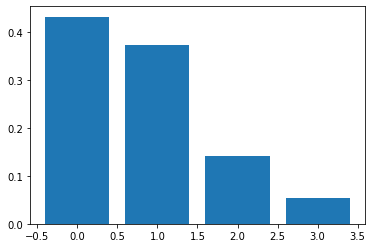

In [205]:
# Obtenemos la importancia de las variables  en el modelo
importance = rf_classifier.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [206]:
#Nombre de las columnas para saber a qué barra corresponde cada una de las variables. 
variables_importantes_enero.columns.values

array(['num_dt', 'incidencia', 'descuentos', 'imp_financ'], dtype=object)

A partir de esta infomacion podemos decir que estas 4 variables son las que mayormente las que explican el cambio de operadora de muchos clientes entre el mes de diciembre y enero.

La varibale que tuvo más peso en el modelo fue 'num_dt', seguida por 'incidencia', 'descuento' y finalmente 'imp_financ'. 

En resumen, esto quiere decir los clientes que tienen algun tipo de mora y/o incidencia abierta con la empresa son más propensos a marcharse. Los clientes que no tienen ningún tipo de descuento tienen mas probabilidad de cambiarse de empresa ante los que tienen algún descuento.


#### Recomendaciones para la empresa:
- En base a lo estudiado vemos que 1556 clientes tienen una probablididad mayor al 50% de irse de la empresa entre enero y febrero. Por eso recomendamos que,  principalmente a estos clientes, hacerles llegar la campaña de fidelizacion, y en caso de ser necesario ofrecerles algún descuento, ya que esto disminuye la probabilidad de dar de baja el servicio contratado.
- También se recomienda que, principalmente con éstos usuarios, se vea si tienen incidencia y de ser así buscar la manera de solucionarlas. 